# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("b.lestsov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
"""
Реализуется иерархическая кластеризация.

Я использовал следущие оптимизации алгоритма:
1) Матрица расстояний - В начале работы алгоритма строится 
    матрица расстояний между кластерами,
    которая по ходу работы алгоритма обновляется.
    Это нужно для того, чтобы избежать перебора точек в кластерах
    и перерасчета расстояний между ними.
2) Дельта-сет - перебор кластеров происходит не во всем множестве
    кластеров, а только в дельта-сете, который по ходу дела обновляется.
    Благодаря этому, сложность становится заничтельно меньше,
    чем O(n^3), как в оригинальном варианте.

Но даже с учетом этих оптимизаций, алгоритм работает достаточно долго
на полном дата-сете :(
"""


def enum(sequence, start=0):
    """
    Useful function
    """
    n = start
    for elem in sequence[start:]:
        yield n, elem
        n += 1

class Clustering:
    def __init__(self, k, linkage="single"):
        """
        k - number of clusters,
        linkage  - "single" | "complete" | "average"
        """
        if k < 1:
            raise Exception("Wrong number of clusters in constructor")

        self.k = k

        if linkage == "single":
            self.linkage = self._single_linkage
        elif linkage == "complete":
            self.linkage = self._complete_linkage
        elif linkage == "average":
            self.linkage = self._average_linkage
        else:
            raise Exception("Unknown type of linakage")
        return

    def fit(self, x, y=None):

        self.x_len = len(x)

        if self.x_len < 2:
            raise Exception("Length of x vector must be >= 2")
            
        # Эти параметры подобраны эмпирически,
        # но, они, вроде бы неплохо показывают
        # себя при больших x_len
        self.k1 = self.x_len / 5
        self.k2 = self.x_len * 15

        self.clusters = [[i] for i, e in enumerate(x)]
        c = len(self.clusters)

        self.x = x
        self.build_dist_matrix(x)
        self.compute_delta()
        self.build_delta_set()

        while c > self.k:

            c_a = c_b = None
            min_dist = +np.inf
            for i, cl1 in enum(self.delta_set):
                for j, cl2 in enum(self.delta_set, i + 1):
                    d = self.dist(cl1, cl2)
                    if d < min_dist:
                        min_dist = d
                        c_a = i
                        c_b = j
            self.merge(self.delta_set[c_a], self.delta_set[c_b])
            self.update_delta_set(self.delta_set[c_a], self.delta_set[c_b])
            c -= 1

        return self

    def merge(self, c_a, c_b):
        for i in self.clusters[c_b]:
            self.clusters[c_a].append(i)
        del self.clusters[c_b]

        for i, dd in enumerate(self.dist_matrix[c_a]):
            d = self.linkage(self.dist_matrix[c_a, i], self.dist_matrix[c_b, i])
            self.dist_matrix[c_a, i] = d
            self.dist_matrix[i, c_a] = d

        self.dist_matrix = np.delete(self.dist_matrix, c_b, axis=0)
        self.dist_matrix = np.delete(self.dist_matrix, c_b, axis=1)

    def build_dist_matrix(self, x):
        self.dist_matrix = np.zeros(shape=(self.x_len, self.x_len))
        for i in xrange(self.dist_matrix.shape[0]):
            for j in xrange(i + 1, self.dist_matrix.shape[1]):
                dist = self.calc_p_dist(x[i], x[j])
                self.dist_matrix[i, j] = dist
                self.dist_matrix[j, i] = dist

    def compute_delta(self):
        if self.k1 >= len(self.clusters):
            self.delta = +np.inf
        else:
            rand_dists = []
            for i in xrange(self.k2):
                cl1 = np.random.randint(0, self.dist_matrix.shape[0])
                cl2 = np.random.randint(0, self.dist_matrix.shape[0])
                while cl2 == cl1:
                    cl2 = np.random.randint(0, self.dist_matrix.shape[0])
                rand_dists.append(self.dist_matrix[cl1, cl2])
            self.delta = min(rand_dists)

    def build_delta_set(self):
        if self.delta != +np.inf:
            self.delta_set = []
            for i, cl1 in enum(self.clusters):
                for j, cl2 in enum(self.clusters, start=i + 1):
                    if self.dist_matrix[i, j] <= self.delta:
                        if not i in self.delta_set:
                            self.delta_set.append(i)
                        if not j in self.delta_set:
                            self.delta_set.append(j)
            self.delta_set.sort()
        else:
            self.delta_set = range(len(self.clusters))

    def update_delta_set(self, c_a, c_b):
        if len(self.delta_set) != 2:
            self.delta_set.remove(c_b)
            for i, cl in enumerate(self.delta_set):
                if cl > c_b:
                    self.delta_set[i] -= 1
            self.check_delta_set()
        else:
            self.compute_delta()
            self.build_delta_set()

    def check_delta_set(self):
        min_dist = +np.inf
        for i, cl1 in enum(self.delta_set):
            for j, cl2 in enum(self.delta_set, start=i + 1):
                d = self.dist(cl1, cl2)
                if d < min_dist:
                    min_dist = d
            if min_dist > self.delta:
                self.delta_set.remove(cl1)
                if len(self.delta_set) <= 2:
                    self.compute_delta()
                    self.build_delta_set()
                return
        if len(self.delta_set) <= 2:
            self.compute_delta()
            self.build_delta_set()
            return

    def _single_linkage(self, i, j):
        return min(i, j)

    def _complete_linkage(self, i, j):
        return max(i, j)

    def _average_linkage(self, i, j):
        return float(i + j) / 2

    def calc_p_dist(self, p1, p2):
        return np.linalg.norm(p2 - p1)

    def dist(self, c_a, c_b):
        return self.dist_matrix[c_a, c_b]

    def compute_p_to_cl_dist(self, p, cl):
        min_dist = +np.inf
        for cl_p_ind in cl:
            dist = self.calc_p_dist(p, self.x[cl_p_ind])
            if dist < min_dist:
                min_dist = dist
        return min_dist

    def predict(self, x):
        pred = np.zeros(shape=(len(x)), dtype=np.int32)
        for i, p in enumerate(x):
            min_dist = +np.inf
            min_ind = None
            for j, cl in enumerate(self.clusters):
                dist = self.compute_p_to_cl_dist(p, cl)
                if dist < min_dist:
                    min_dist = dist
                    min_ind = j
            pred[i] = min_ind
        return pred

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

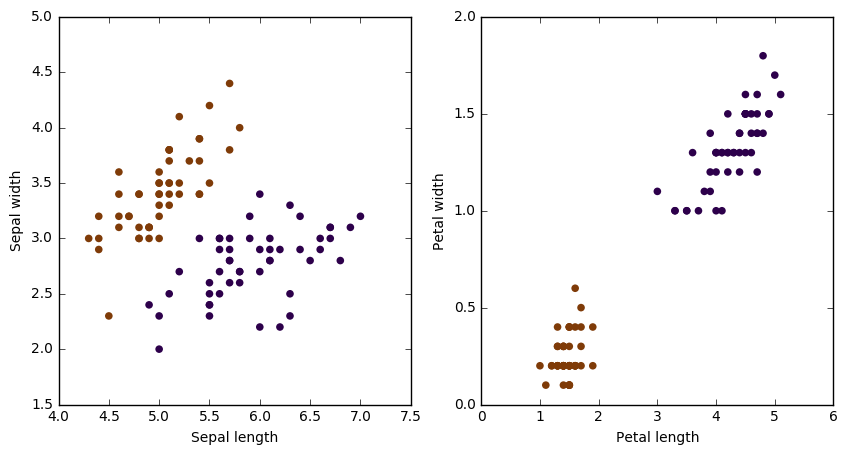

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
pred_iris = Clustering(k=2, linkage = "single").fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [7]:
def quality(x, y, p_dist):
    """
    Average diameter
    """
    n_clusters = len(np.unique(y))
    diameters = np.zeros(n_clusters)
    for cls in xrange(n_clusters):
        max_dist = -np.inf
        for j, c in enumerate(y):
            if cls == y[j]:
                p = x[j]
                cls_pts = []
                for j, x_p in enumerate(x):
                    if y[j] == cls:
                        cls_pts.append(x_p)
                for cls_p in cls_pts:
                    d = p_dist(p, cls_p)
                    if d > max_dist:
                        max_dist = d
        diameters[cls] = max_dist
    sum = 0.0
    for i in diameters:
        sum += i
    return sum/n_clusters

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

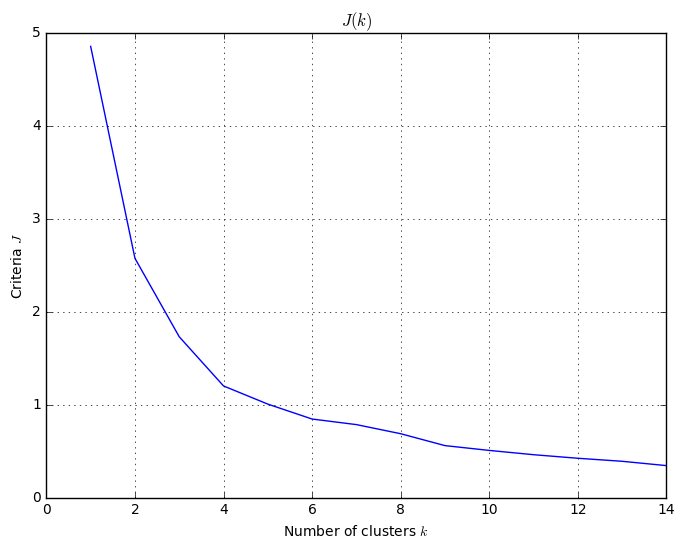

In [8]:
"""
На нашем дата-сете вычисление этой клетки займет ооочень долгое время.
Поэтому, в качестве примера здесь - Iris dataset.
"""

ks = range(1, 15)
criteria = np.zeros(len(ks))

for i, n_clus in enumerate(ks):
    cls = Clustering(k=n_clus)
    y = cls.fit_predict(x_iris)
    criteria[i] = quality(x_iris, y, cls.calc_p_dist)

pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [10]:
k = 5
cls = Clustering(k=5, linkage="average")
y = cls.fit_predict(x)

# На всякий случай
with open("y.json", "w+") as f:
    json.dump(y.tolist(), f)
with open("clss.json", "w+") as f:
    json.dump(cls.clusters, f)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11434
[t-SNE] Computed conditional probabilities for sample 2000 / 11434
[t-SNE] Computed conditional probabilities for sample 3000 / 11434
[t-SNE] Computed conditional probabilities for sample 4000 / 11434
[t-SNE] Computed conditional probabilities for sample 5000 / 11434
[t-SNE] Computed conditional probabilities for sample 6000 / 11434
[t-SNE] Computed conditional probabilities for sample 7000 / 11434
[t-SNE] Computed conditional probabilities for sample 8000 / 11434
[t-SNE] Computed conditional probabilities for sample 9000 / 11434
[t-SNE] Computed conditional probabilities for sample 10000 / 11434
[t-SNE] Computed conditional probabilities for sample 11000 / 11434
[t-SNE] Computed conditional probabilities for sample 11434 / 11434
[t-SNE] Mean sigma: 0.063874
[t-SNE] Error after 100 iterations with early exaggeration: 1.421907
[t-SNE] Error

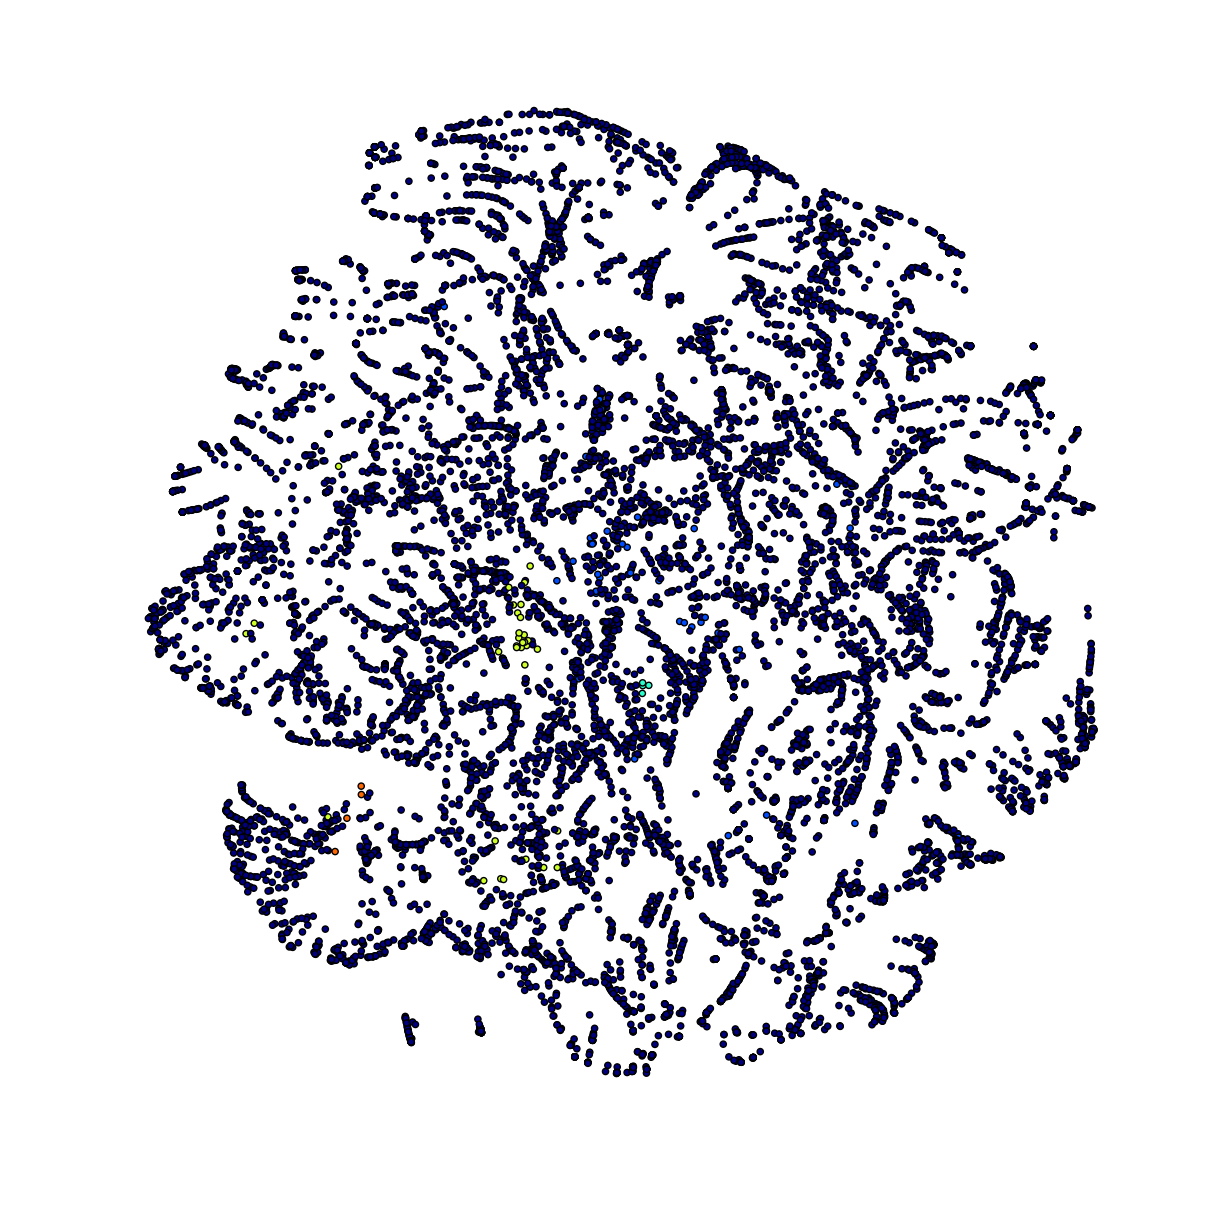

In [11]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

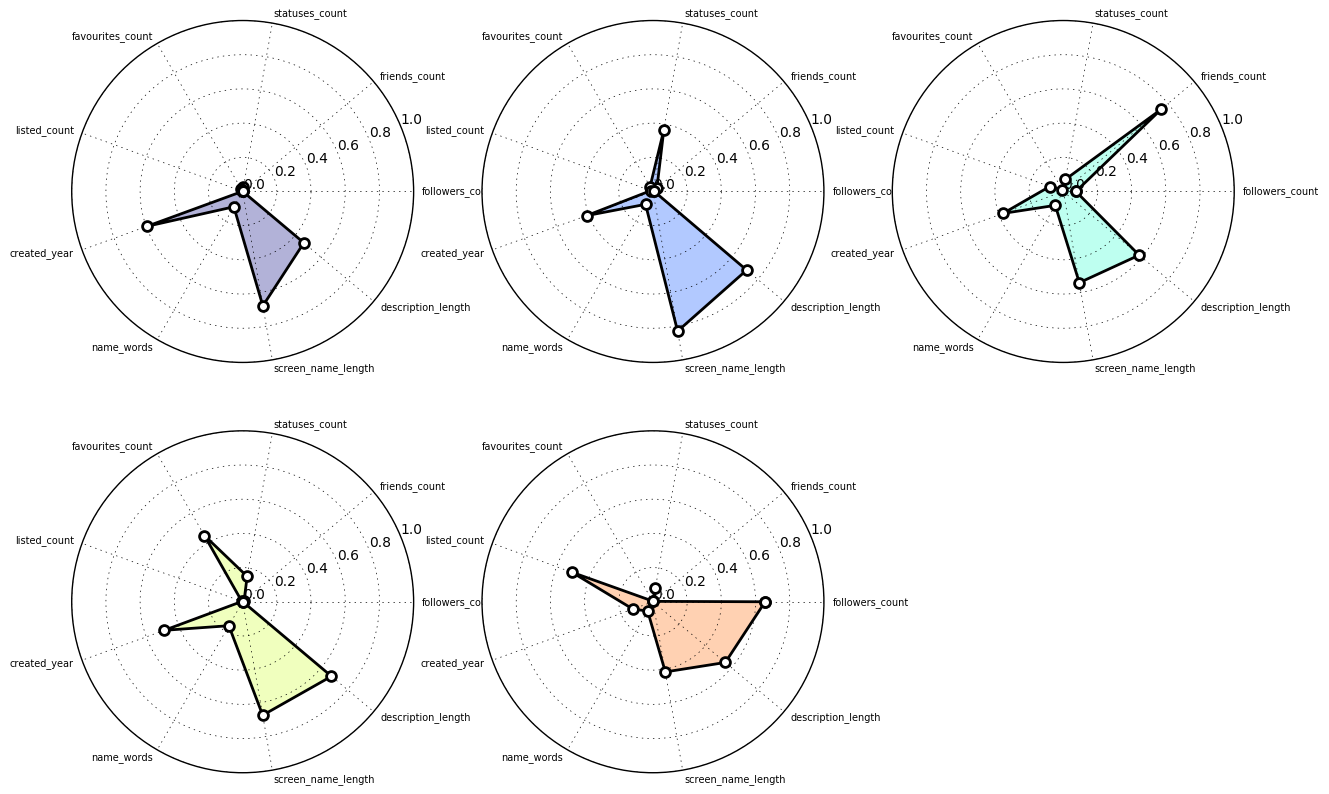

In [12]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.